<a href="https://colab.research.google.com/github/jjgl0540-hub/GEOG5415/blob/main/notebooks/GEOG5415M_Final_Project_202018307_02_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GEOG5415M Final Assignment (Template)

Student ID number:202018307

In [ ]:
# read in required packages

# import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd

In [ ]:
# configure plotting settings
%matplotlib inline
sns.set_theme(style="whitegrid")

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This is an example block of mardown text I want to reference <a href="#ref1">[1]</a>. I might need to add some more citations <a href="#ref2">[2]</a><a href="#ref2">[3]</a>



# **1. Introduction & Data Sources**

This project develops a spatial data analysis workflow to identify variations in energy vulnerability across Leeds. While national energy support policies in the UK are often income-based, they may overlook households that face high energy costs due to poor building efficiency rather than low income alone.

To address this, the project integrates Energy Performance Certificate (EPC) data with selected sociodemographic indicators from the 2021 UK Census.


*   EPC data offers the most detailed energy efficiency records for English residential buildings in terms of building structure, heating systems, and insulation performance—factors that directly determine energy expenditures, aspects that income alone cannot measure.
*   The 2021 census data identifies social groups more vulnerable to energy risks through factors like central heating type, population composition, and income deprivation.



Leeds was selected as the case study because of its diverse housing stock (large-scale Victorian terraced houses) and clearly defined neighbourhood structures, which make it suitable for aggregating EPC records and census indicators at the LSOA level. Local policymakers and energy planners are the target audience for this analysis, as they can leverage this type of spatial evidence to develop more targeted and context-sensitive energy support programs.




**Data Sources:**







*   EPC Data: Sourced from DLUHC (Domestic Energy Performance Certificates), aggregated to LSOA level to represent average housing efficiency.
*   Census 2021: Sourced from NOMIS, providing student population,central heating fuel types and tenure status per LSOA.


*   LSOA Boundaries: Sourced from ONS Geoportal for spatial mapping.





# **2. Programming Workflow & Data preparation**

The programming workflow for this project consists of three stages: data preparation, spatial analysis, and data visualization. This chapter focuses on the data preparation stage, covering the loading, cleaning, aggregation, and integration of multi-source data.



**2.1 Data Loading**


Data comes from various institutions with different file structures and coverage. Common challenges include inconsistent column names, missing shared identifiers, inconsistent coordinate systems, and missing data. To address these issues, we establish a standardized data loading and verification process to ensure the consistency and comparability of the data before analysis.





In [ ]:
# load the data
epc=pd.read_csv('/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/epc_leeds_2025.csv')
imd=pd.read_csv('/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/imd_2019.csv')
lsoa=gpd.read_file('/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/LSOA/LSOA_2021_EW_BGC_V5.shp')


/tmp/ipython-input-2001626475.py:2: DtypeWarning: Columns (15,37,39,40,83) have mixed types. Specify dtype option on import or set low_memory=False.
  epc=pd.read_csv('/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/epc_leeds_2025.csv')


The 2021 census data (from NOMIS) contains multiple rows of metadata headers, and we develop an auxiliary function to uniformly parse all relevant files.

In [ ]:
# load remaining data

# NOMIS census files contain metadata in the first few rows
# define a helper function to skip these headers automatically
# consistent parsing across all census datasets.
def read_nomis_csv(path, skiprows=7):
    return pd.read_csv(path, skiprows=skiprows)

# load census attributes using the helper function
heating=read_nomis_csv('/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/census_heating_2021.csv')
students=read_nomis_csv('/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/census_students_2021.csv')
tenure=read_nomis_csv('/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/census_tenure_2021.csv')

**2.2 Spatial Linkage**

In [ ]:
# after loading each dataset, basic data integrity checks (such as structure and completeness) were performed.
# this demonstration shows the checks performed on the EPC dataset.

# check the key columns to confirm the existence of energy efficiency rating variables
# required to be aggregated to the LSOA level later.
epc.head()

,LMK_KEY,ADDRESS1,ADDRESS2,ADDRESS3,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,...,CONSTITUENCY_LABEL,POSTTOWN,CONSTRUCTION_AGE_BAND,LODGEMENT_DATETIME,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN,UPRN_SOURCE,REPORT_TYPE
0,001dca82162cbdf798f746f53027c0cc82afda971d5e84...,Flat 2,35a Town Street,Farsley,LS28 5HX,10003805692,E,C,42,70,...,Pudsey,PUDSEY,England and Wales: before 1900,2022-12-06 16:54:30,Rented (private),9.0,NaN,72736113.0,Energy Assessor,100
1,18a413eb393a87aaccdcbbc35d75c519a13bf9713e5d8d...,8 Sackville Street,NaN,NaN,LS7 2AS,10003489215,D,B,61,82,...,Leeds North East,LEEDS,England and Wales: 1900-1929,2022-10-03 15:40:47,Rented (private),12.0,NaN,72658276.0,Energy Assessor,100
2,18ad988b1d1a739e5adfd04531c27c63e7ea810f40c31d...,20 Highfield Gardens,NaN,NaN,LS12 4DU,10003423919,C,B,72,86,...,Leeds West,LEEDS,England and Wales: 2007-2011,2022-10-25 07:49:22,Rented (social),6.0,NaN,72683080.0,Energy Assessor,100
3,18bd4432597b334e2d8031b1ded0e4d713f2133e939b89...,17 Chestnut Gardens,NaN,NaN,LS12 4LP,10002989904,B,A,88,92,...,Leeds West,Leeds,England and Wales: 1983-1990,2022-10-06 16:09:42,Owner-occupied,7.0,NaN,72266470.0,Address Matched,100
4,275687798052018050310193492080467,"9, Foxwood Farm Way",NaN,NaN,LS8 3EE,4759821668,D,B,58,87,...,Leeds East,LEEDS,England and Wales: 1983-1990,2018-05-03 10:19:34,owner-occupied,NaN,NaN,72269527.0,Address Matched,100


A critical issue identified during inspection was the absence of LSOA codes in the raw EPC dataset. To resolve this, this study adopted a postcode-based linkage strategy. A lookup table (ONSPD) was utilized to map individual postcodes to their corresponding LSOA codes.

In [ ]:
# since epc dataset does not have an encoding like lsoa_code
# it needs to be converted first
# load the file that converts postcode
lookup=pd.read_csv("/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/PCD_OA21_LSOA21.csv")

# keep only the necessary fields and use consistent column names
lookup=lookup[["pcds", "lsoa21cd"]].rename(columns={"pcds": "postcode","lsoa21cd": "lsoa_code"})

# clean the postcode (to be consistent with EPC)
lookup["postcode_clean"]=(lookup["postcode"].astype(str).str.upper().str.replace(" ", "", regex=False))

# keep only the two columns needed for the join
lookup=lookup[["postcode_clean", "lsoa_code"]]


/tmp/ipython-input-341271602.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  lookup=pd.read_csv("/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415M/data/raw/PCD_OA21_LSOA21.csv")


In [ ]:
# clean epc postcodes for reliable matching (uppercase + remove spaces)
epc["postcode_clean"]=(epc["POSTCODE"].astype(str).str.upper().str.replace(" ", "", regex=False))

# add lsoa_code to epc dataset
epc=epc.merge(lookup,on="postcode_clean",how="left")

# check the match rate
print(epc['lsoa_code'].notna().mean())

# randomly select several samples
epc[['POSTCODE', 'postcode_clean', 'lsoa_code']].sample(10, random_state=42)

0.9988389184944723


,POSTCODE,postcode_clean,lsoa_code
12561,LS7 2QE,LS72QE,E01011450
26108,LS7 3ER,LS73ER,E01011360
281043,LS28 5LW,LS285LW,E01011593
317456,LS18 4DH,LS184DH,E01011465
4183,LS4 2NG,LS42NG,E01011479
181626,LS12 1DH,LS121DH,E01033015
111460,LS16 7AT,LS167AT,E01011384
396899,LS20 9EY,LS209EY,E01011279
22246,LS10 3SQ,LS103SQ,E01032498
205074,LS3 1BX,LS31BX,E01035045


**2.3 Data Aggregation**

All attribute datasets are spatially joined with the official LSOA boundary file.
As EPC data contains residential-level energy efficiency information, which needs to be aggregated to the LSOA level for spatial comparison with the census data at first. The mean current energy efficiency score is used as the summary indicator, enabling integrated analysis across different spatial scales.

In [ ]:
# convert the EPC energy efficiency column to numerical values ​​(for calculating the average)
for c in ["CURRENT_ENERGY_EFFICIENCY", "POTENTIAL_ENERGY_EFFICIENCY"]:
    if c in epc.columns:
        epc[c]=pd.to_numeric(epc[c], errors="coerce")

In [ ]:
# re-aggregate and analyze the scores of individual buildings according to LSOA partitions

# aggregate EPC records by LSOA
# remove EPC records without LSOA code
epc_clean=epc.dropna(subset=["lsoa_code"])

# group EPC records by LSOA
epc_grouped=epc_clean.groupby("lsoa_code")

# summarise building-level EPC indicators at the LSOA level to enable spatial comparison
epc_lsoa=epc_grouped.agg(mean_current_eff=("CURRENT_ENERGY_EFFICIENCY", "mean"),mean_potential_eff=("POTENTIAL_ENERGY_EFFICIENCY", "mean"),
    n_properties=("LMK_KEY", "count")).reset_index()

In [ ]:
# standardise LSOA identifiers to enable consistent joins across census tables
heating=heating.rename(columns={"mnemonic": "lsoa_code"})
students=students.rename(columns={"mnemonic": "lsoa_code"})
tenure=tenure.rename(columns={"mnemonic": "lsoa_code"})
imd=imd.rename(columns={"LSOA code (2011)": "lsoa_code"})

In [ ]:
# combine a census table
lsoa_census=(heating.merge(students, on="lsoa_code", how="left").merge(tenure, on="lsoa_code", how="left").merge(imd, on="lsoa_code", how="left"))

In [ ]:
# process LSOA datasets
# uniform key column naming and screen out Leeds' LSOA
lsoa=lsoa.rename(columns={"LSOA21CD": "lsoa_code"})
lsoa_leeds=lsoa[lsoa['lsoa_code'].isin(lsoa_census["lsoa_code"])].copy()

# merge Geometry + Census Attributes + EPC Data
lsoa_geo=(lsoa_leeds.merge(lsoa_census, on="lsoa_code", how="left").merge(epc_lsoa, on="lsoa_code", how="left"))

In [ ]:
# check the first few rows to confirm everything is there
lsoa_geo.head(3)

,lsoa_code,LSOA21NM,LSOA21NMW,BNG_E,BNG_N,LAT,LONG,GlobalID,geometry,2021 super output area - lower layer_x,...,Outdoors Sub-domain Rank (where 1 is most deprived),Outdoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs),Total population: mid 2015 (excluding prisoners),Dependent Children aged 0-15: mid 2015 (excluding prisoners),Population aged 16-59: mid 2015 (excluding prisoners),Older population aged 60 and over: mid 2015 (excluding prisoners),Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners),mean_current_eff,mean_potential_eff,n_properties
0,E01011264,Leeds 011A,None,420937,441836,53.8723,-1.68306,64fb7b6a-27ee-4fa8-a1ca-4afde43ea40d,"POLYGON ((421354.761 442327.389, 421423.688 44...",Leeds 011A,...,14415.0,5.0,1252.0,188.0,653.0,411.0,665.0,61.625616,78.948276,406
1,E01011265,Leeds 009A,None,418988,441951,53.8734,-1.71270,fbdef384-ef8d-4255-b68e-6b2aed79304d,"POLYGON ((418598.68 442761.477, 418637.555 442...",Leeds 009A,...,17248.0,6.0,1788.0,321.0,999.0,468.0,1007.0,66.603521,78.628667,1193
2,E01011266,Leeds 008A,None,417489,442615,53.8795,-1.73546,ba94fe93-06c4-4c65-b854-97028172e051,"POLYGON ((418337 441566, 418335.674 441589.328...",Leeds 008A,...,18531.0,6.0,2381.0,483.0,1431.0,467.0,1444.0,66.552332,77.223834,965


In [ ]:
lsoa_geo.columns


Index(['lsoa_code', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG',
       'GlobalID', 'geometry', '2021 super output area - lower layer_x',
       'Total: All households_x', 'No central heating', 'Mains gas only',
       'Tank or bottled gas only', 'Electric only', 'Oil only', 'Wood only',
       'Solid fuel only', 'Renewable energy only',
       'District or communal heat networks only', 'Other central heating only',
       'Two or more types of central heating (not including renewable energy)',
       'Two or more types of central heating (including renewable energy)',
       '2021 super output area - lower layer_y', 'Total', 'Student',
       'Not a student', '2021 super output area - lower layer',
       'Total: All households_y', 'Owned', 'Shared ownership', 'Social rented',
       'Private rented', 'Lives rent free',
       'Owns with a mortgage or loan or shared ownership',
       'Private rented or lives rent free', 'LSOA name (2011)',
       'Local Authority Distric

After aggregation, the merged files need to be checked to ensure that a unified and comparable spatial unit base is provided for subsequent spatial analysis and visualization.

Number of LSOAs with EPC data: 511
Total number of Leeds LSOAs (geometry): 488


<Axes: >

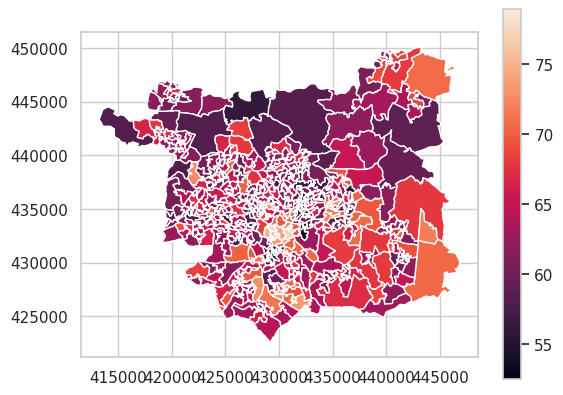

In [ ]:
# spatial sanity checks
# coverage check: number of LSOAs represented in each dataset
x_epc_lsoa=epc_lsoa["lsoa_code"].nunique()
x_lsoa_geo=lsoa_geo["lsoa_code"].nunique()

print(f"Number of LSOAs with EPC data: {x_epc_lsoa}")
print(f"Total number of Leeds LSOAs (geometry): {x_lsoa_geo}")

# visual sanity check (should only show Leeds area)
lsoa_geo.plot(column="mean_current_eff", legend=True)

In [ ]:
# check missing EPC values after spatial merge
lsoa_geo[["mean_current_eff", "mean_potential_eff", "n_properties"]].isna().sum()


,0
mean_current_eff,0
mean_potential_eff,0
n_properties,0


In [ ]:
# check space merging status
lsoa_geo.geometry.is_valid.all()

np.True_

Final checks confirm the dataset is analytically robust, consistently aligned with the 488 Leeds LSOAs, and contains complete records for all study variables.

In [ ]:

#lsoa_geo.to_file("/content/drive/MyDrive/Leeds_Energy_Project_GEOG5415/data/lsoa_ready.geojson",driver="GeoJSON")

**2.4 Exploratory check of raw variables**

To better understand the limitations of using a single indicator, an exploratory check was conducted to examine the relationship between income deprivation and housing energy efficiency at the LSOA level. The figure presents a scatter plot of the income deprivation score against mean EPC current efficiency.

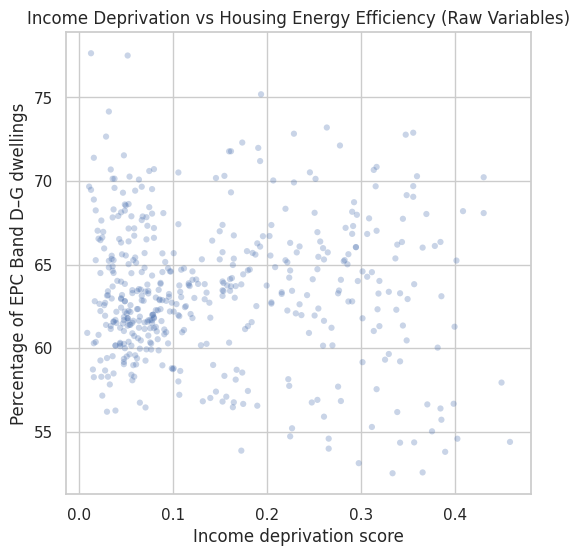

In [79]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    gdf["Income Score (rate)"],        # raw income deprivation
    gdf["mean_current_eff"],               # % EPC Band D–G
    alpha=0.3,
    s=20,
    edgecolors="none"
)

ax.set_xlabel("Income deprivation score")
ax.set_ylabel("Percentage of EPC Band D–G dwellings")
ax.set_title("Income Deprivation vs Housing Energy Efficiency (Raw Variables)")

plt.show()



The scatter shows substantial dispersion and no clear linear relationship, suggesting that income deprivation alone is insufficient to characterise variation in housing energy efficiency across areas.


# **Visualisation & Interpretation**

In [ ]:
PHYSICAL_COL = "mean_current_eff"
ECON_COL     = "Income Score (rate)"
LSOA_NAME_COL = "LSOA21NM"

In [ ]:
required_cols = [PHYSICAL_COL, ECON_COL, "geometry"]
missing = []
for c in required_cols:
    if c not in lsoa_geo.columns:
        missing.append(c)

if len(missing) > 0:
    raise KeyError(f"Missing columns: {missing}")

gdf = lsoa_geo.copy()
gdf = gdf[gdf.geometry.notnull()].copy()

**3.1 “Cold Index” Scatter (validate the “ignored group” idea)**

Building on the observation that income deprivation alone does not adequately capture variation in housing energy efficiency, the following analysis adopts a multidimensional perspective to examine cold-related vulnerability. To operationalise this, economic and physical dimensions are jointly considered.

This section examines the relationship between these two dimensions using a scatter plot of standardised variables. Both measures are expressed as z-scores, with reference lines at zero indicating average conditions across all LSOAs, allowing areas to be interpreted in relative terms across four quadrants.



In [ ]:
def zscore(s):
    return (s - s.mean()) / s.std()

# standardise variables so they are comparable
gdf["phys_poverty_z"] = zscore(-gdf[PHYSICAL_COL])
gdf["econ_poverty_z"] = zscore(gdf[ECON_COL])

# combine physical and economic poverty into a single index
gdf["cold_index"] = (gdf["phys_poverty_z"] + gdf["econ_poverty_z"]) / 2


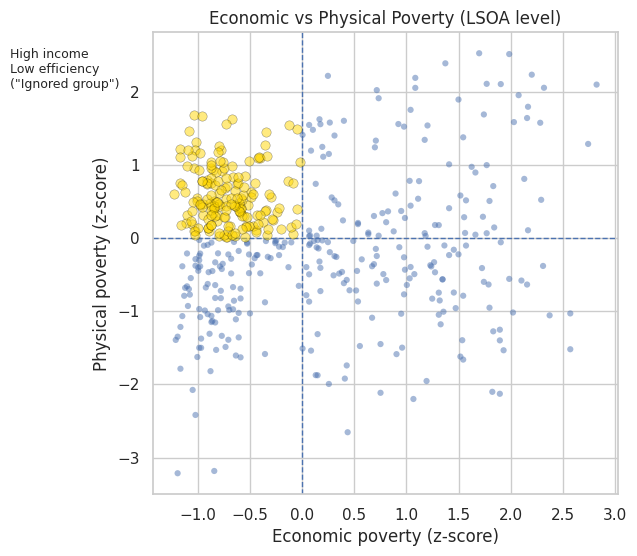

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

# define ignored group (upper-left quadrant)
ignored = gdf[(gdf["econ_poverty_z"] < 0) & (gdf["phys_poverty_z"] > 0)]

# background points = everything except ignored
rest = gdf[~((gdf["econ_poverty_z"] < 0) & (gdf["phys_poverty_z"] > 0))]

# plot background
ax.scatter(rest["econ_poverty_z"], rest["phys_poverty_z"],alpha=0.5, s=20,edgecolors="none", linewidths=0,zorder=1)

# reference lines at mean (z=0)
ax.axhline(0, linestyle="--", linewidth=1)
ax.axvline(0, linestyle="--", linewidth=1)

# plot highlighted group
ax.scatter(ignored["econ_poverty_z"], ignored["phys_poverty_z"],color="gold", alpha=0.5, s=45,edgecolors="black", linewidths=0.3,zorder=3)

ax.set_xlabel("Economic poverty (z-score)")
ax.set_ylabel("Physical poverty (z-score)")
ax.set_title("Economic vs Physical Poverty (LSOA level)")

ax.text(-2.8, 2.6, "High income\nLow efficiency\n(\"Ignored group\")", fontsize=9, ha="left", va="top")

plt.show()

The figure shows that economic and physical poverty are only weakly correlated overall. A distinct cluster of areas appears in the upper-left quadrant, characterised by relatively high income levels but poor physical housing efficiency.

These areas would be overlooked by income-based targeting alone, motivating the construction of a composite cold index in the following section.

**3.2 Static Map: Bivariate Choropleth (economic poverty × physical poverty)**
Figure 3.2: Bivariate choropleth (3×3 or 4×4 classes)

Identify spatial risk patterns:

A: “double poverty” (low income + low efficiency)

B: “physical poverty” only

C: “economic poverty” only

**3.3 Interactive Map: Local Moran’s I clusters (and tooltips)**

Figure 3.3: Interactive cluster map (Local Moran’s I)

Tooltip: show key attributes (EPC efficiency, income/IMD, students/tenure/fuel, etc.)

This is “where clusters are” + “what’s inside those areas”

**Limitations & Ethical Considerations**

**Conclusion**

Data Visualisation
- Don't forget to present your final two data visualisation (one spatial and one non-spatial) and the justifications about the decisions you made whilst preparing and visualising the data.

## References
<p><a href="add_url_here">[1]</a>Footnote citation goes here</p>
<p><a href="https://github.com/FrancescaPontin/GEOG5415M-Programming-for-Spatial-Data-Science">[2]</a>GEOG5415M course materials</p>
<p><a href="add_url_here">[3]</a>Citation 3</p>